In [1]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() # GPU 사용 확인 코드

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16544876351814084817
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4859428864
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15823631640043444466
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

## 10.

*문제: 심층 MLP를 MNIST 데이터셋에 훈련해보세요(`keras.datasets.mnist.load_data()` 함수를 사용해 데이터를 적재할 수 있습니다). 98% 이상의 정확도를 얻을 수 있는지 확인해보세요. 이 장에서 소개한 방법을 사용해 최적의 학습률을 찾아보세요(즉 학습률을 지수적으로 증가시키면서 손실을 그래프로 그립니다. 그다음 손실이 다시 증가하는 지점을 찾습니다). 모든 부가 기능을 추가해보세요. 즉, 체크포인트를 저장하고, 조기 종료를 사용하고, 텐서보드를 사용해 학습 곡선을 그려보세요.*

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


패션 MNIST 데이터셋처럼 MNIST 훈련 세트는 28x28 픽셀의 흑백 이미지 60,000개로 이루어져 있습니다:

In [4]:
X_train_full.shape

(60000, 28, 28)

각 픽셀 강도는 바이트(0~255)로 표현됩니다:

In [5]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (더 작은) 훈련 세트로 나누어 보겠습니다. 패션 MNIST처럼 픽셀 강도를 255로 나누어 0-1 범위의 실수로 변환합니다:

In [6]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 이미지 샘플 몇 개를 출력해 보죠:

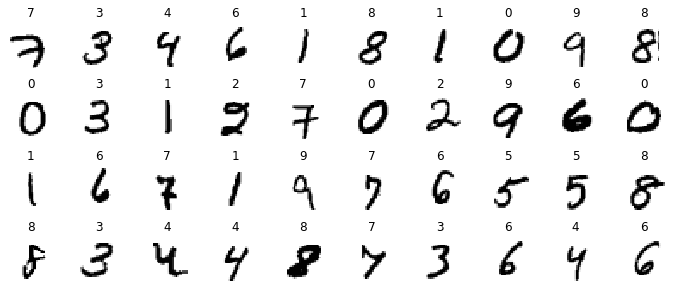

In [46]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

간단한 밀집 신경망을 만들고 최적의 학습률을 찾아 보겠습니다. 반복마다 학습률을 증가시키기 위해 콜백을 사용합니다. 이 콜백은 반복마다 학습률과 손실을 기록합니다:

In [47]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [48]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [49]:
'''model.summary()'''

'model.summary()'

In [50]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

작은 학습률 1e-3에서 시작하여 반복마다 0.5%씩 증가합니다:

In [51]:
expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])
#model.save("ann_prac_10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.3945 - accuracy: 0.1135


[2.3944895267486572, 0.11349999904632568]

Text(0, 0.5, 'Loss')

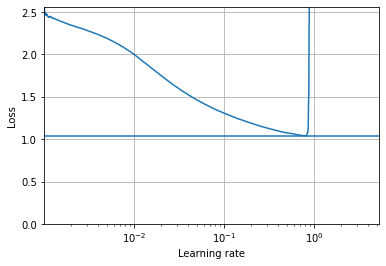

In [52]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [54]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [55]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [56]:
run_index = 1 # 실행할 때마다 이 값을 늘립니다
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("ann_prac_10.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0945 - accuracy: 0.9703 - val_loss: 0.0902 - val_accuracy: 0.9740
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0672 - accuracy: 0.9787 - val_loss: 0.0842 - val_accuracy: 0.9784
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.0792 - val_accuracy: 0.9786
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0346 - accuracy: 0.9885 - val_loss: 0.0812 - val_accuracy: 0.9796
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0783 - val_accuracy: 0.9806
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0260 - accuracy: 0.9916 - val_loss: 0.0770 - val_a

In [58]:
model = keras.models.load_model("ann_prac_10.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0848 - accuracy: 0.9783


[0.08480130136013031, 0.9782999753952026]

정확도는 97.82% 마지막으로 텐서보드를 사용해 학습 곡선:

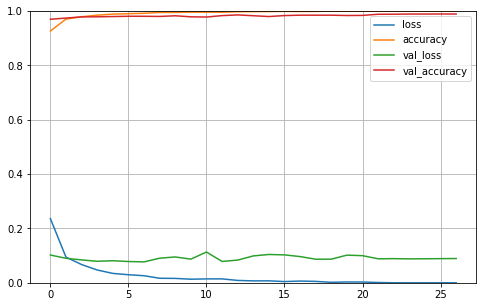

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [62]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6007